## Homework 2 - Part 2 - Task 2: GMM and PCA
Gaussian Mixture Model(GMM) and PCA <br>
We will use face image dataset to build GMM model to generate new face images <br>
GMM is very slow for high dimentional data <br>
To speed-up GMM, we will apply PCA to the input images. <br>
image samples => forward PCA => samples in a lower-dimensional space => GMM <br>
GMM => random sampling => new samples in a lower-dimensional space => inverse PCA => new images <br>
This is a guided-task: <br>
You will see the output of a code cell and then figure out the code in that cell. <br>
In each code cell, there are instructions to help you. <br>
This is a very efficient and effective way to learn how to program with sk-learn <br>
see GMM_DE_Generative_Model.ipynb

### Create your "signature"
Run the cell below but do NOT modify the cell. \
The signature needs to be displayed right below the cell in this file. \
You will get zero point if the signature is not displayed. 

In [72]:
import platform, socket, getpass
from time import time
from datetime import datetime
import random
signature=[socket.gethostbyname(socket.gethostname()),
           getpass.getuser(),
           datetime.now(),
           random.random()]
print(signature) 

['10.5.0.2', 'ARamo', datetime.datetime(2025, 9, 29, 22, 48, 31, 755924), 0.436775599845318]


In [73]:
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
sn.set(style='whitegrid')
from sklearn.mixture import GaussianMixture as GMM

### Load image data

In [74]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=500)
print(faces.target_names)
print(faces.images.shape)

['George W Bush']
(530, 62, 47)


check the total number of samples/images, `N`

In [75]:
#what is N ?
N=faces.images.shape[0]
N

530

check the input dimension (the number of elements in each input sample), `M`

In [76]:
#what is M?
M=faces.images.shape[1]*faces.images.shape[2]
M

2914

Next let's plot the first 100 of these to recall exactly what we're looking at:

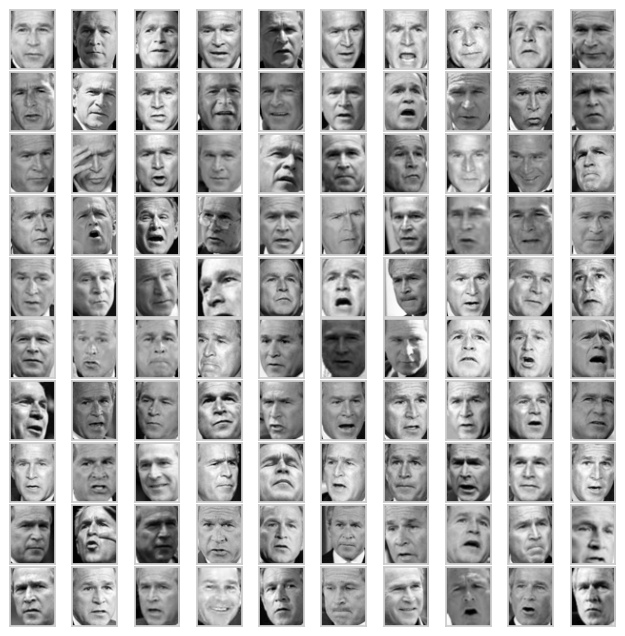

In [77]:
#contact TA or instructor if this cell does not work properly
def plot_faces(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8), subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i], cmap='gray')
plot_faces(faces.images)

We have N images, and each image has M pixels <br>
N = 530  <  M = 2914 <br>
the number of samples is smaller than the dimension <br>
We will use dimension reduction to reduce the number of features

## Your work begins here
### Apply PCA to images

In [78]:
# apply PCA to images
# you may need this: images.reshape(N,-1)
# set PCA parameter n_components to 120
# set whiten=True to use the normalized features
# assume data = pca.fit_transform(...)
# your code:
from sklearn.decomposition import PCA
pca = PCA(n_components=120, whiten=True)
data = pca.fit_transform(faces.images.reshape(N, -1))

In [79]:
#check the shape of data
# your code:
data.shape

(530, 120)

In [80]:
#obtain the value of cumulative explained variance ratio when "n_components"=120
#i.e., the percentage of the variance that is explained when "n_components"=120
#hint: read explained_variance_ratio_ at https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
# your code:
explained_var = np.cumsum(pca.explained_variance_ratio_)
explained_var[-1]

np.float32(0.9459079)

### Fit GMM 
Afer PCA transform, the number of features is changed from 2914 (62*47) to 120 <br>
N = 530,  data.shape[1] = 120 <br>
Now, we fit many GMM to `data` with different number of components <br>
We will select the best one based on AIC

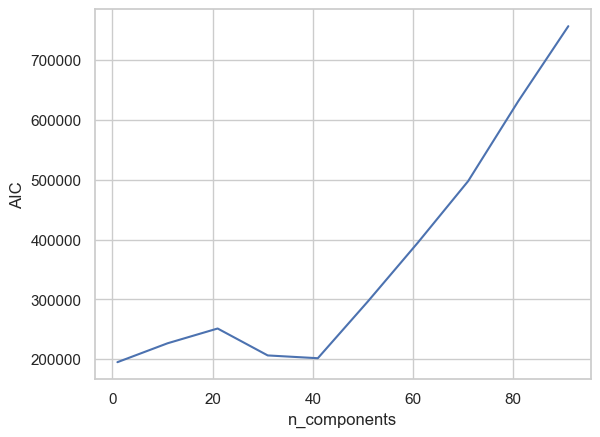

In [81]:
#fit GMM with n_components in the range of 1 to 100 with step 10
n_components = np.arange(1, 100, 10)
# your code:
aics = []
for n in n_components:
    gmm = GMM(n_components=n, covariance_type='full', random_state=0)
    gmm.fit(data.astype(np.float64)) # !
    aics.append(gmm.aic(data))
plt.plot(n_components, aics)
plt.xlabel('n_components')
plt.ylabel('AIC')
plt.show()

Overall, the curve keeps going up: something is weird. <br>
What will the curve be if we have more data to train GMM ? <br>
note: you may get a different curve due to some randomness in initialization.

It looks like when n_components= ?? AIC reaches the minimum. <br>
Let's fit the GMM with n_components=?? (when AIC is minimum), and check if gmm is converged or not 

In [82]:
# write code to find the best n_components
# your code:
best_n = n_components[np.argmin(aics)]

# fit GMM (name is gmm in the code) using the best n_components
# your code:
gmm = GMM(n_components=best_n, covariance_type='full', random_state=0)
gmm.fit(data.astype(np.float64)) # !

#---------
#check if the gmm model fitting process is converged
print(gmm.converged_)

True


Draw 100 new samples from GMM (gmm) <br>
The new data samples are in the 120-dimensional projected space

In [83]:
#write code to generate data_new from the gmm
# your code:
data_new, _ = gmm.sample(100)

#then check the shape
data_new.shape

(100, 120)

Finally, we can transform the 100 samples back to the original space (pca inverse) <br>
and plot some of the images in the original space <br>

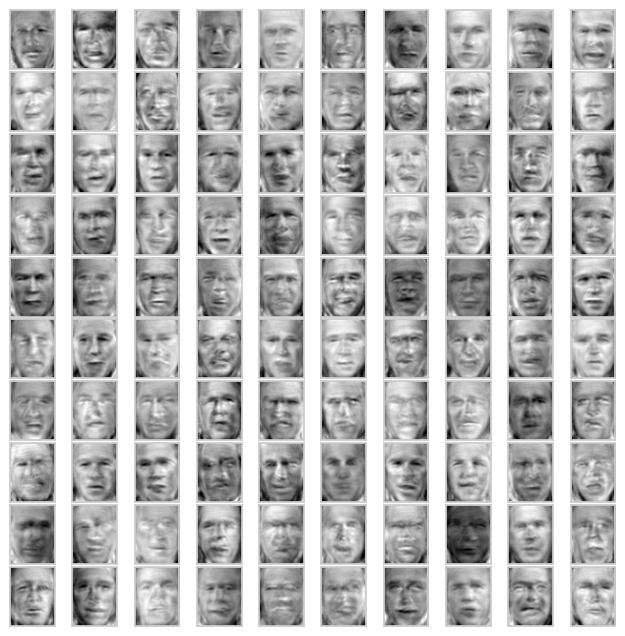

In [84]:
# write code to obtain faces_new by applying inverse pca on data_new
# your code:
faces_new = pca.inverse_transform(data_new)

# show the new images
plot_faces(faces_new.reshape(-1,62, 47))

### Let's repeat the above process using more data

In [85]:
#do not change the code in this cell
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=50)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Jacques Chirac' 'John Ashcroft' 'Junichiro Koizumi'
 'Serena Williams' 'Tony Blair']
(1434, 62, 47)


In [86]:
#check the number of images
# N = ?
# your code:
N = faces.images.shape[0]
# Create reshaped data for reuse in second part
face_reshaped = faces.images.reshape(N, -1)
N

1434

In [87]:
#check the input dimension (the number of elements in each input sample)
# M = ?
# your code:
M = faces.images.shape[1] * faces.images.shape[2]
M

2914

We have N images, and each iamge has M pixels  <br>
N = 1560 and M = 2914 : N < M  <br>
We will use dimension reduction to reduce the number of features from 2914 to 120 <br>

In [88]:
# apply PCA to images
# set PCA parameter n_components to 120
# assume data = pca.fit_transform(...)
# your code:
pca = PCA(n_components=120, whiten=True)
data = pca.fit_transform(face_reshaped)

In [89]:
#check the shape of data
# your code:
data.shape

(1434, 120)

In [90]:
#check the value of cumulative explained variance ratio
# your code:
explained_var = np.cumsum(pca.explained_variance_ratio_)
explained_var[-1]

np.float32(0.9203592)

Now, we fit many GMMs to the transformed `data` with different number of components   <br>
We will select the best one based on AIC

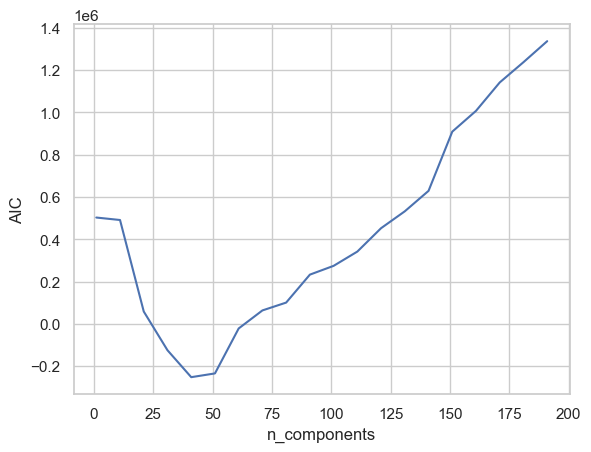

In [91]:
#fit GMM with n_components in the range of 1 to 200 with the step of 10
# your code:
n_components = np.arange(1, 200, 10)
aics = []
for n in n_components:
    gmm = GMM(n_components=n, covariance_type='full', random_state=0)
    gmm.fit(data.astype(np.float64)) # !
    aics.append(gmm.aic(data))
plt.plot(n_components, aics)
plt.xlabel('n_components')
plt.ylabel('AIC')
plt.show()

Now, we have a U-haped curve, nice. (again, you may get a different curve) <br>
It appears that AIC is miminized around 60 components. <br>
What is the exact value of n_components when AIC is minimum?

In [92]:
#write code to find out the exact value of n_components when AIC is minimum
#you may get a different number due to randomness in GMM
# your code:
best_n = n_components[np.argmin(aics)]
best_n

np.int64(41)

Let's quickly fit GMM with n_components=?? (when AIC is minimum) to the `data` and confirm that it has converged:

In [93]:
# fit the GMM with n_components = the value when AIC is minimum
# your code:
gmm = GMM(n_components=best_n, covariance_type='full', random_state=0, reg_covar=1e-5)
gmm.fit(data.astype(np.float64)) # !
print(gmm.converged_)

True


Generate 100 new samples from this GMM

In [94]:
#write code to generate data_new from gmm
# your code:
data_new, _ = gmm.sample(100)

#then check the shape
data_new.shape

(100, 120)

Transform the 100 new samples back to the original space

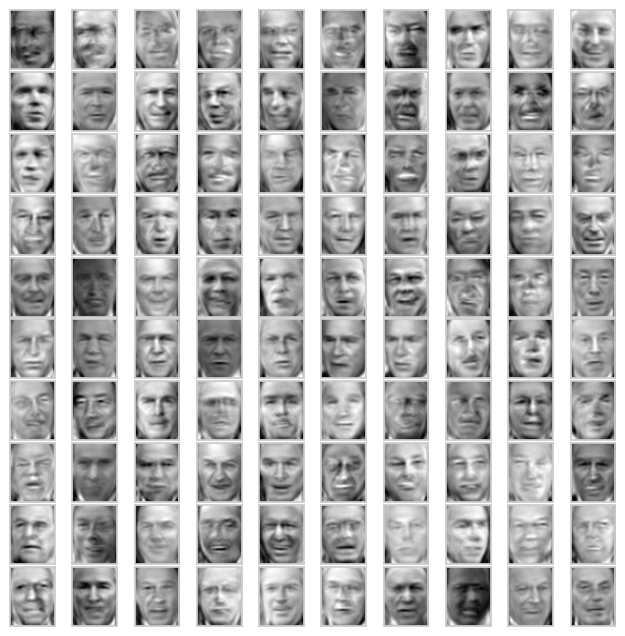

In [95]:
# write code to obtain faces_new by apply inverse pca on data_new
# your code:
faces_new = pca.inverse_transform(data_new)

# show the new images
plot_faces(faces_new.reshape(-1,62, 47))

GMM is good but very time consuming. PCA+GMM is a good approach to reduce time cost.